# MNISTを拡散モデルで学習する

## セットアップ

In [1]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.9 MB/s eta 0:00:00


In [20]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from diffusers import DDPMScheduler, UNet2DModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


途中過程は飛ばして
[より改良した学習](#scrollTo=NxAqgjhXd0mD)
や
[衣類の画像データセットを学習する](#scrollTo=vqSprzIlk6-4)
から実行することもできます．

## 学習データの用意

In [3]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [4]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([2, 2, 5, 0, 7, 8, 4, 6])


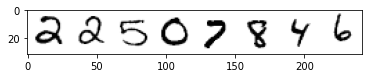

In [5]:
# データを取り出して例示
x, y = next(iter(loader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

## 画像にノイズを加える

画像に各要素がランダムのベクトルを加えることで，ノイズを加えることができます．

元の画像は28px*28pxで各ピクセルが0\~1の実数値なので，ノイズを加えた後もおおよそ0\~1になるようにしてみます．

0\~1の乱数を振ってランダムなベクトルを作成し，元画像と混合します．

In [6]:
def corrupt(x, amount):
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1)
  return x*(1-amount) + noise*amount 

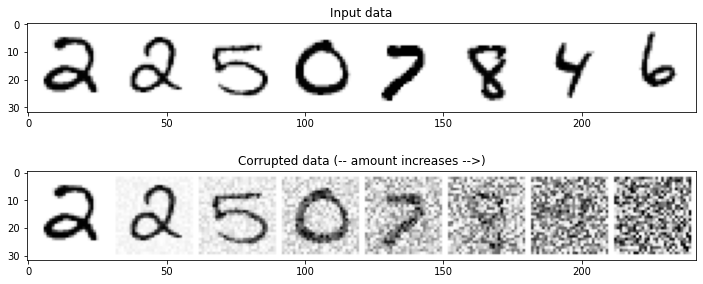

In [8]:
# ノイズが加わる様子を可視化
amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

_, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')
plt.show()

Schedulerはパラメータ(時刻)tに対して，そのとき混合の割合を決めます．

時刻が経つほどにノイズを増やしていくイメージです．

パラメータに対して線形にノイズを乗せていくのか，  
別の関数を用いてノイズ加えていくかについては様々な手法が考案されています．

以下は一例です．

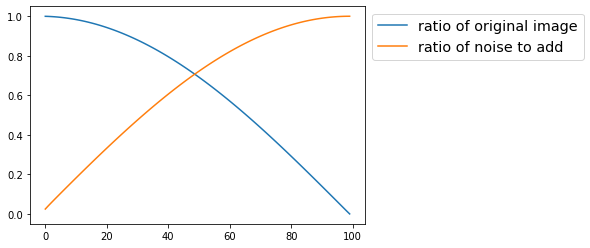

In [16]:
num_train_timesteps = 100
noise_scheduler = DDPMScheduler(num_train_timesteps, beta_schedule="squaredcos_cap_v2")

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label="ratio of original image")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label="ratio of noise to add")
plt.legend(fontsize="x-large", loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

1000
tensor([797, 481, 701, 454, 217, 744, 383, 427])


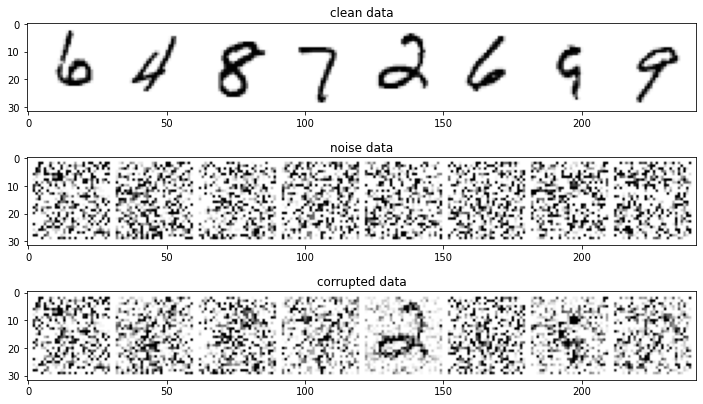

In [18]:
clean_examples, _ = next(iter(loader))

noises = torch.randn(clean_examples.shape)
example_scheduler = DDPMScheduler(1000, beta_schedule="squaredcos_cap_v2")

bs = clean_examples.shape[0]
timesteps = torch.randint(0, example_scheduler.num_train_timesteps, (bs,)).long()
print(example_scheduler.num_train_timesteps)
print(timesteps)

noisy_examples = example_scheduler.add_noise(clean_examples, noises, timesteps)

_, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('clean data')
axs[0].imshow(torchvision.utils.make_grid(clean_examples)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('noise data')
axs[1].imshow(torchvision.utils.make_grid(noises)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('corrupted data')
axs[2].imshow(torchvision.utils.make_grid(noisy_examples)[0].clip(0, 1), cmap='Greys')
plt.show()

## 学習に用いるモデル

拡散モデルではUNetが用いられます．

画像を畳み込み込んで行から広げて戻します．

ResNetを並列させたような構造のネットワークを用います．


In [19]:
def init_unet():
    net = UNet2DModel(
        sample_size=28,
        in_channels=1, 
        out_channels=1,
        layers_per_block=2,
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",
            "AttnDownBlock2D",
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D", 
            "AttnUpBlock2D",
            "UpBlock2D",
        ),
    )
    return net

In [7]:
### ネットワークの内容を確認
net = init_unet()
print(net)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Con

In [8]:
# 出力サイズが入力サイズと等しいことの確認
x = torch.rand(8, 1, 28, 28)
t = torch.rand(8)
net(x, t)[0].shape

torch.Size([8, 1, 28, 28])

In [9]:
# パラメータ数
sum([p.numel() for p in net.parameters()])

1707009

## 学習させる

### ノイズ量による条件付け

学習に用いるモデルは，入力にノイズのかかった画像と，ノイズの量に関するパラメータの2つを取ります．

ノイズを除去してMNISTの10個の数字の画像を得る方法を学習することができます．



Schedulerは使わずにノイズの混合割合をモデルに入力しても，そこそこ学習することができます．

In [38]:
num_epochs = 5

batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

net = init_unet()
net.to(device)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss_history = []
for epoch in range(num_epochs):
    for x, _ in train_dataloader:
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x, noise_amount).sample
        loss = loss_func(pred, x)

        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
        loss_history.append(loss.item())

    avg_loss = sum(loss_history[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

Finished epoch 0. Average loss for this epoch: 0.022912
Finished epoch 1. Average loss for this epoch: 0.015969
Finished epoch 2. Average loss for this epoch: 0.013855
Finished epoch 3. Average loss for this epoch: 0.012816
Finished epoch 4. Average loss for this epoch: 0.012039


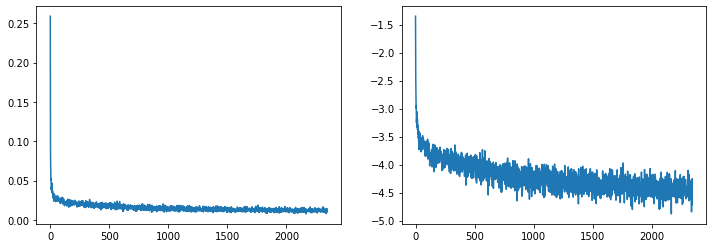

In [39]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(loss_history)
axs[1].plot(np.log(loss_history))
plt.show()

サンプリングする時は，ノイズが多い状態から始めて減らしていけば良いので，  
単純に時刻を後ろから辿ってみます．

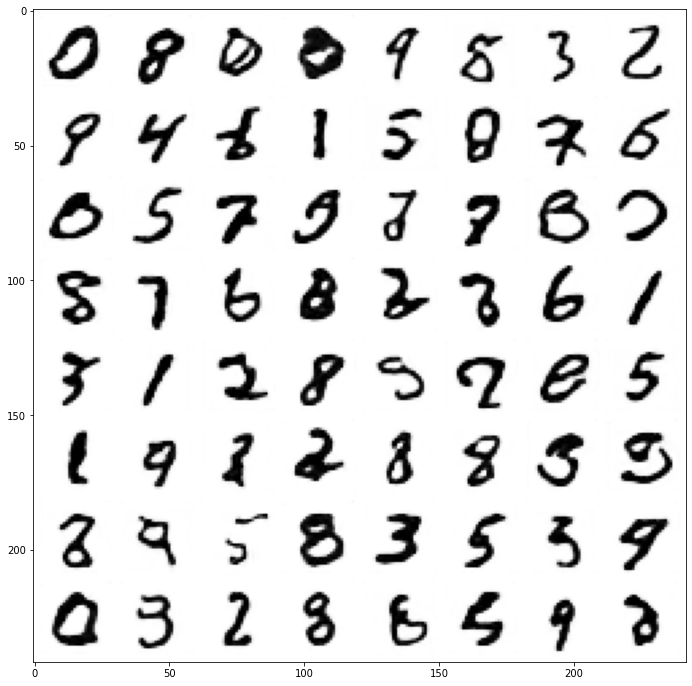

In [42]:
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps))
  with torch.no_grad():
    pred = net(x, noise_amount).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

_, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
plt.show()

### Schedulerによるノイズ付加

単純にノイズの混合割合を入力するのではなく，Schedulerを用います．

ノイズに関するパラメータに対して加わるノイズの量が線形ではなくなり，  
やや表現力が上がって誤差の減りが良さそうに見えます．

Schedulerによる計算が入るので，先ほどのような単純なサンプリングでは綺麗な画像が得られないことに注意してください．

In [6]:
num_epochs = 5

batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_train_timesteps = len(train_dataloader)
noise_scheduler = DDPMScheduler(num_train_timesteps, beta_schedule="squaredcos_cap_v2")

net = init_unet()
net.to(device)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss_history = []
for epoch in range(num_epochs):
    for x, _ in train_dataloader:
        x = x.to(device)

        noise = torch.rand_like(x)
        timesteps = torch.randint(0, num_train_timesteps, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        pred = net(noisy_x, timesteps).sample
        loss = loss_func(pred, x)

        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
        loss_history.append(loss.item())

    avg_loss = sum(loss_history[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

Finished epoch 0. Average loss for this epoch: 0.020818
Finished epoch 1. Average loss for this epoch: 0.013339
Finished epoch 2. Average loss for this epoch: 0.011432
Finished epoch 3. Average loss for this epoch: 0.010673
Finished epoch 4. Average loss for this epoch: 0.010166


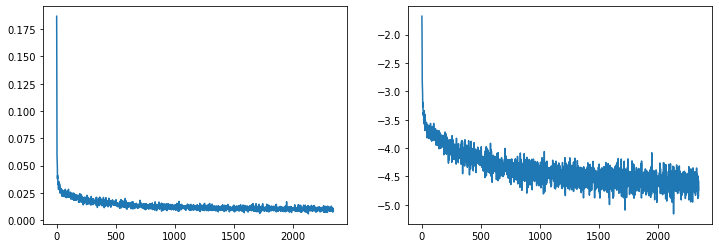

In [23]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(loss_history)
axs[1].plot(np.log(loss_history))
plt.show()

## より改良した学習

### 学習データに対する前処理

Schedulerに実装されたサンプリングを使うためにも，各ピクセルの値を-1~1に標準化します．


モデルの中では2の冪乗になることを見越してサイズを32px*32pxにします．

In [ ]:
image_size = 32
batch_size = 256

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=preprocess)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
x = next(iter(train_dataloader))
x[0].shape

せっかくなのでUNetもパラメータを増やしてみます．

In [ ]:
model = UNet2DModel(
    sample_size=image_size,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)
model.to(device)

In [ ]:
# 出力サイズが入力サイズと等しいことの確認
x = torch.rand(8, 1, 32, 32).to(device)
t = torch.rand(8).to(device)
model(x, t, return_dict=False)[0].shape

### ノイズを学習させる

拡散モデルでは，ノイズが乗った画像からノイズを除去する方法そのものを学習させるのではなく，  
加えられたノイズを推定することが多いです．

In [ ]:
num_epochs = 5
losses = []

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch[0].to(device)
        noise = torch.randn(clean_images.shape).to(clean_images.device)

        batch_size = clean_images.shape[0]
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch_size,), device=device).long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # ノイズを推定する
        pred = model(noisy_images, timesteps, return_dict=False)[0]
        loss = loss_func(pred, noise)

        loss.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(loss_history)
axs[1].plot(np.log(loss_history))
plt.show()

### サンプリングを行う

Pipelineを使うことで簡単にサンプリング結果を得ることができます．

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipeline_output = image_pipe()
pipeline_output.images[0]

サンプリングの中身を示します．

モデルによる推論結果は，入力画像にかけられたノイズ部分です．

Schedulerは元画像と時刻を入力し，内部で乱数からノイズを生成し，ノイズが乗った画像を作ります．

ノイズが乗った画像と時刻とノイズを入力して，元画像を得ることができるでしょう．

In [ ]:
sample = torch.randn(64, 1, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = model(sample, t).sample
    sample = noise_scheduler.step(residual, t, sample).prev_sample

_, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(sample.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
plt.show()

# 衣類の画像データセットを学習する

衣類の画像データセットであるFashion-MNISTを学習してみます．

MNISTと同じく，28px*28pxの白黒画像が10クラス分あります．

手書き数字よりも複雑な形をしています．

In [ ]:
image_size = 32
batch_size = 256

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

# MNIST -> FashionMNIST
dataset = torchvision.datasets.FashionMNIST(root="mnist/", train=True, download=True, transform=preprocess)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# 中身の確認
x = next(iter(train_dataloader))

_, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x[0].detach().cpu(), nrow=16)[0].clip(0, 1), cmap='Greys')
plt.show()

In [ ]:
num_epochs = 10
losses = []

model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch[0].to(device)
        noise = torch.randn(clean_images.shape).to(clean_images.device)

        batch_size = clean_images.shape[0]
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch_size,), device=device).long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # ノイズを推定する
        pred = model(noisy_images, timesteps, return_dict=False)[0]
        loss = loss_func(pred, noise)

        loss.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(loss_history)
axs[1].plot(np.log(loss_history))
plt.show()

In [ ]:
sample = torch.randn(64, 1, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = model(sample, t).sample
    sample = noise_scheduler.step(residual, t, sample).prev_sample

_, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(sample.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
plt.show()